In [1]:
import tweepy
import pandas as pd

In [2]:
# API Key setup
api_key = 'XLrT4TY4C8ZdIFQOMri1QX6Cc'
api_secret_key = 'nFdnp9YT30Omojj9JZdtqD6j6qKP6vvuo65FjLOt6Fe0eotwpZ'
access_token = '3083368926-c7fXpsH0k1Hrqs6bNe7954RMMp7viwgK7paRuHX'
access_token_secret = 'bTTr0tiF4Xizcnjj7gGS1efzhSN5Co8Cgcc0P1cHjMXeF'
# Bearer token from Twitter API v2
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJttvwEAAAAAve3ZMFPG3IVh5poNuakDQUxLo%2Fw%3DcdUn78VL26nE15hTVzu9hjKEl1raNd8xRnvL00uVVloJABXMSD'

In [3]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [4]:
import tweepy
import logging

# Create client for Twitter API v2
client = tweepy.Client(bearer_token=bearer_token)

# Query tweets using the v2 API
query = 'attrition risk OR employee turnover OR workplace stress OR HR issues lang:en'
response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=100)

# Store tweet details in a DataFrame
tweet_data = []
for tweet in response.data:
    tweet_data.append([tweet.created_at, tweet.author_id, tweet.text])

df_tweets = pd.DataFrame(tweet_data, columns=['Timestamp', 'Author_ID', 'Tweet'])

# Display first few rows
print(df_tweets.head())


                  Timestamp            Author_ID  \
0 2024-10-06 11:00:33+00:00            360220091   
1 2024-10-06 10:54:32+00:00           1574757961   
2 2024-10-06 10:52:21+00:00  1419755916094853122   
3 2024-10-06 10:49:33+00:00  1081362021948506117   
4 2024-10-06 10:47:04+00:00           4689967196   

                                               Tweet  
0  Low pay, high staff turnover and employee burn...  
1  @JustMariner @airindia Yes, it can if only it ...  
2  @Maceroni2000 @rtenews That’s the story that’s...  
3  RT @aiboc_in: 5-Day Work Week: A Standard for ...  
4  RT @ProfCong: As the tragic death of young Ann...  


In [5]:
import re

def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    return text.strip().lower()

df_tweets['Cleaned_Tweet'] = df_tweets['Tweet'].apply(clean_tweet)
print(df_tweets[['Tweet', 'Cleaned_Tweet']].head())


                                               Tweet  \
0  Low pay, high staff turnover and employee burn...   
1  @JustMariner @airindia Yes, it can if only it ...   
2  @Maceroni2000 @rtenews That’s the story that’s...   
3  RT @aiboc_in: 5-Day Work Week: A Standard for ...   
4  RT @ProfCong: As the tragic death of young Ann...   

                                       Cleaned_Tweet  
0  low pay high staff turnover and employee burno...  
1  yes it can if only it tries to find out why th...  
2  thats the story thats not being discussed howe...  
3  rt  day work week a standard for productivity ...  
4  rt  as the tragic death of young anna sebastia...  


In [6]:
from transformers import pipeline

# Load sentiment-analysis pipeline
sentiment_model = pipeline('sentiment-analysis')

# Apply sentiment analysis
df_tweets['Sentiment'] = df_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])

print(df_tweets[['Cleaned_Tweet', 'Sentiment']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                       Cleaned_Tweet Sentiment
0  low pay high staff turnover and employee burno...  NEGATIVE
1  yes it can if only it tries to find out why th...  NEGATIVE
2  thats the story thats not being discussed howe...  NEGATIVE
3  rt  day work week a standard for productivity ...  POSITIVE
4  rt  as the tragic death of young anna sebastia...  NEGATIVE


C:\Users\hp\AppData\Local\Temp\ipykernel_6340\472202984.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


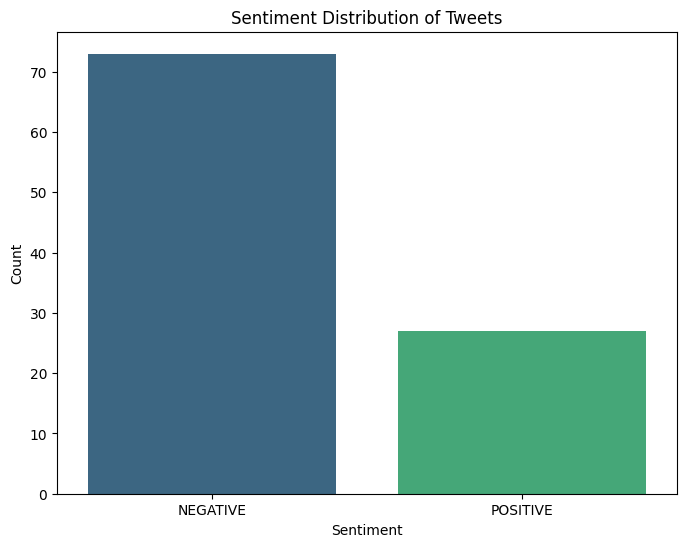

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the sentiment occurrences
sentiment_counts = df_tweets['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Tweets')
plt.show()


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df_tweets['Cleaned_Tweet'])

# Convert to DataFrame
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming you have labels for training
y = df_tweets['Sentiment'] 

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    NEGATIVE       0.95      0.91      0.93        23
    POSITIVE       0.75      0.86      0.80         7

    accuracy                           0.90        30
   macro avg       0.85      0.89      0.87        30
weighted avg       0.91      0.90      0.90        30



In [10]:
import time
import logging
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

def process_tweets():
    tweet_count = 0
    max_tweets = 5
    
    while tweet_count < max_tweets:
        start_time = time.time()
        
        try:
            # Fetch new tweets
            fetch_start = time.time()
            response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=10)
            if response.data is None:
                logger.warning("No tweets found.")
                time.sleep(60)  # Sleep and retry if no tweets
                continue
            fetch_time = time.time() - fetch_start
            
            # Process and clean tweets
            process_start = time.time()
            new_tweets = pd.DataFrame([[tweet.created_at, tweet.author_id, tweet.text] for tweet in response.data], columns=['Timestamp', 'Author_ID', 'Tweet'])
            new_tweets['Cleaned_Tweet'] = new_tweets['Tweet'].apply(clean_tweet)
            process_time = time.time() - process_start
            
            # Extract features
            feature_start = time.time()
            new_features = vectorizer.transform(new_tweets['Cleaned_Tweet'])
            df_new_features = pd.DataFrame(new_features.toarray(), columns=vectorizer.get_feature_names_out())
            feature_time = time.time() - feature_start
            
            # Predict attrition risk
            predict_start = time.time()
            predictions = model.predict(df_new_features)
            predict_time = time.time() - predict_start
            
            # Output predictions and increment tweet_count
            for tweet, prediction in zip(new_tweets['Tweet'], predictions):
                if tweet_count < max_tweets:
                    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")
                    tweet_count += 1
                else:
                    break
            
            # Log times
            logger.info(f"Fetch time: {fetch_time:.2f} seconds")
            logger.info(f"Process time: {process_time:.2f} seconds")
            logger.info(f"Feature extraction time: {feature_time:.2f} seconds")
            logger.info(f"Prediction time: {predict_time:.2f} seconds")
        
        except Exception as e:
            logger.error(f"An error occurred: {e}")
            break
        
        if tweet_count < max_tweets:
            # Sleep for a while before fetching new tweets
            time.sleep(60)  # Fetch new tweets every 1 minute
    
    print("Processed 5 tweets. Exiting...")

# Run the real-time processing function
process_tweets()


INFO:root:Fetch time: 0.52 seconds
INFO:root:Process time: 0.00 seconds
INFO:root:Feature extraction time: 0.00 seconds
INFO:root:Prediction time: 0.01 seconds


Tweet: Low pay, high staff turnover and employee burnout took a toll on social service nonprofits during the COVID-19 pandemic - https://t.co/YdpSEl06bg
Prediction: NEGATIVE

Tweet: @JustMariner @airindia Yes, it can if only it tries to find out why the attitude has been cropped. 

The 'Chalta hi' attitude comes from poor infrastructure, staff shortage, poor IT, bad HR practices and no attention to building the processes.

Employees can't be blamed till one fixes these issues.
Prediction: NEGATIVE

Tweet: @Maceroni2000 @rtenews That’s the story that’s not being discussed. However it does appear as though the references were checked with an HR officer &amp; I think that’s where the issues arise
Prediction: NEGATIVE

Tweet: RT @aiboc_in: 5-Day Work Week: A Standard for Productivity, Growth &amp; Efficiency and a norm for ethical workplace.

Across sectors globally,…
Prediction: POSITIVE

Tweet: RT @ProfCong: As the tragic death of young Anna Sebastian showed, office stress &amp; toxic wo

### Applying LLM --> GPT2

In [11]:
from transformers import pipeline

# Initialize the sentiment-analysis pipeline
sentiment_model = pipeline('sentiment-analysis')


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
# Apply sentiment analysis using the LLM
df_tweets['LLM_Sentiment'] = df_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])

print(df_tweets[['Cleaned_Tweet', 'LLM_Sentiment']].head())


                                       Cleaned_Tweet LLM_Sentiment
0  low pay high staff turnover and employee burno...      NEGATIVE
1  yes it can if only it tries to find out why th...      NEGATIVE
2  thats the story thats not being discussed howe...      NEGATIVE
3  rt  day work week a standard for productivity ...      POSITIVE
4  rt  as the tragic death of young anna sebastia...      NEGATIVE


In [13]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Initialize GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# def generate_topics(text, max_input_length=50, max_new_tokens=20):
#     # Truncate the input text if it's longer than the max_input_length
#     inputs = tokenizer.encode(text[:max_input_length], return_tensors='pt')
    
#     # Generate topics with a set number of new tokens
#     outputs = model.generate(inputs, max_new_tokens=max_new_tokens, num_return_sequences=1)
    
#     return tokenizer.decode(outputs[0], skip_special_tokens=True)

# # Apply topic generation to the cleaned tweets
# df_tweets['Generated_Topics'] = df_tweets['Cleaned_Tweet'].apply(generate_topics)

# # Display the results
# print(df_tweets[['Cleaned_Tweet', 'Generated_Topics']].head())


In [23]:
# Set the tokenizer's pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token

def generate_topics(text, max_input_length=50, max_new_tokens=20):
    if not text or len(text.strip()) == 0:  # Check if the text is empty
        return "No Content"
    
    # Tokenize the input text, add attention mask, and truncate if needed
    inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_input_length)
    
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Generate topics with a set number of new tokens, pass attention mask
    outputs = model.generate(input_ids, 
                             attention_mask=attention_mask, 
                             max_new_tokens=max_new_tokens, 
                             pad_token_id=tokenizer.eos_token_id,
                             num_return_sequences=1)
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Ensure no empty or NaN values in the 'Cleaned_Tweet' column
df_tweets['Cleaned_Tweet'] = df_tweets['Cleaned_Tweet'].fillna("")

# Apply topic generation to the cleaned tweets
df_tweets['Generated_Topics'] = df_tweets['Cleaned_Tweet'].apply(generate_topics)

# Display the results
print(df_tweets[['Cleaned_Tweet', 'Generated_Topics']].head())


                                       Cleaned_Tweet  \
0  low pay high staff turnover and employee burno...   
1  yes it can if only it tries to find out why th...   
2  thats the story thats not being discussed howe...   
3  rt  day work week a standard for productivity ...   
4  rt  as the tragic death of young anna sebastia...   

                                    Generated_Topics  
0  low pay high staff turnover and employee burno...  
1  yes it can if only it tries to find out why th...  
2  thats the story thats not being discussed howe...  
3  rt  day work week a standard for productivity ...  
4  rt  as the tragic death of young anna sebastia...  


In [15]:
def process_tweets_with_llm():
    tweet_count = 0  # Counter for the number of tweets processed
    
    while tweet_count < 5:  # Loop until 5 tweets are processed
        # Fetch new tweets
        response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=10)
        
        # Process and clean tweets
        new_tweets = pd.DataFrame([[tweet.created_at, tweet.author_id, tweet.text] for tweet in response.data], columns=['Timestamp', 'Author_ID', 'Tweet'])
        new_tweets['Cleaned_Tweet'] = new_tweets['Tweet'].apply(clean_tweet)
        
        # Apply LLM sentiment analysis
        new_tweets['LLM_Sentiment'] = new_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])
        
        # Output results
        for tweet, sentiment in zip(new_tweets['Tweet'], new_tweets['LLM_Sentiment']):
            print(f"Tweet: {tweet}\nLLM Sentiment: {sentiment}\n")
            tweet_count += 1
            if tweet_count >= 5:
                break
        
        # If 5 tweets have been printed, exit the loop
        if tweet_count >= 5:
            break

# Run the real-time processing function with LLM
process_tweets_with_llm()

Tweet: Low pay, high staff turnover and employee burnout took a toll on social service nonprofits during the COVID-19 pandemic - https://t.co/YdpSEl06bg
LLM Sentiment: NEGATIVE

Tweet: @JustMariner @airindia Yes, it can if only it tries to find out why the attitude has been cropped. 

The 'Chalta hi' attitude comes from poor infrastructure, staff shortage, poor IT, bad HR practices and no attention to building the processes.

Employees can't be blamed till one fixes these issues.
LLM Sentiment: NEGATIVE

Tweet: @Maceroni2000 @rtenews That’s the story that’s not being discussed. However it does appear as though the references were checked with an HR officer &amp; I think that’s where the issues arise
LLM Sentiment: NEGATIVE

Tweet: RT @aiboc_in: 5-Day Work Week: A Standard for Productivity, Growth &amp; Efficiency and a norm for ethical workplace.

Across sectors globally,…
LLM Sentiment: POSITIVE

Tweet: RT @ProfCong: As the tragic death of young Anna Sebastian showed, office stress &a

In [17]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

# Define test paths
test_tokenizer_path = r'C:\temp\tokenizer'
test_model_path = r'C:\temp\model'

# Create test directories
os.makedirs(test_tokenizer_path, exist_ok=True)
os.makedirs(test_model_path, exist_ok=True)

# Save the tokenizer and model to the test directories
tokenizer.save_pretrained(test_tokenizer_path)
model.save_pretrained(test_model_path)


Part 2: Predictive Models for Skillsets


In [36]:
import tweepy
import logging

# Create client for Twitter API v2
client = tweepy.Client(bearer_token=bearer_token)

# Query tweets using the v2 API
query = '("skills required" OR "we are hiring" OR "job opening" OR "looking for developers with skills") lang:en'
response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=100)

# Store tweet details in a DataFrame
tweet_data = []
for tweet in response.data:
    tweet_data.append([tweet.created_at, tweet.author_id, tweet.text])

df_tweets = pd.DataFrame(tweet_data, columns=['Timestamp', 'Author_ID', 'Tweet'])

# Display first few rows
print(df_tweets.head())


                  Timestamp            Author_ID  \
0 2024-10-06 11:31:39+00:00  1682698398816927745   
1 2024-10-06 11:31:34+00:00  1170003237849616385   
2 2024-10-06 11:31:29+00:00  1819801514925494272   
3 2024-10-06 11:30:41+00:00  1674839832340594704   
4 2024-10-06 11:29:49+00:00  1812607915670327296   

                                               Tweet  
0  RT @lustingforlala: We are hiring !!!! 🫣 https...  
1  RT @lustingforlala: We are hiring !!!! 🫣 https...  
2  RT @TheMonsterApp: 🔥Monster app is recruiting ...  
3  RT @lustingforlala: We are hiring !!!! 🫣 https...  
4  RT @lustingforlala: We are hiring !!!! 🫣 https...  


In [41]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure you have downloaded the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Sample function to clean and preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Example DataFrame
data = pd.DataFrame({
    'job_descriptions': [
        "Data Analyst with expertise in Python, SQL, and data analysis.",
        "Machine Learning Engineer: Python, SQL, and data modeling required.",
        "Looking for a Data Scientist with skills in Python, pandas, numpy, and machine learning.",
        "Job requires Tableau experience and data visualization skills."
    ]
})

# Apply preprocessing
data['processed'] = data['job_descriptions'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
from sklearn.feature_extraction.text import CountVectorizer

# Join tokens back into strings for vectorization
data['processed_str'] = data['processed'].apply(lambda x: ' '.join(x))

# Create a CountVectorizer to transform the text into a matrix of token counts
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_str'])

# View the feature names (words)
print(vectorizer.get_feature_names_out())


['analysis' 'analyst' 'data' 'engineer' 'experience' 'expertise' 'job'
 'learning' 'looking' 'machine' 'modeling' 'numpy' 'pandas' 'python'
 'required' 'requires' 'scientist' 'skills' 'sql' 'tableau'
 'visualization']


In [43]:
from sklearn.cluster import KMeans

# Choosing the number of clusters
num_clusters = 4  # Adjust as necessary
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign clusters back to the original DataFrame
data['cluster'] = kmeans.labels_


In [44]:
# Function to display top terms for each cluster
def display_cluster_terms(model, vectorizer, num_words=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        top_terms = [terms[ind] for ind in order_centroids[i, :num_words]]
        print("Top terms:", top_terms)

# Display the cluster terms
display_cluster_terms(kmeans, vectorizer)


Cluster 0:
Top terms: ['modeling', 'learning', 'sql', 'data', 'engineer', 'required', 'python', 'machine', 'analyst', 'experience']
Cluster 1:
Top terms: ['visualization', 'skills', 'data', 'requires', 'experience', 'job', 'tableau', 'looking', 'analyst', 'engineer']
Cluster 2:
Top terms: ['data', 'analysis', 'sql', 'analyst', 'python', 'expertise', 'looking', 'engineer', 'experience', 'job']
Cluster 3:
Top terms: ['skills', 'scientist', 'data', 'python', 'pandas', 'numpy', 'machine', 'looking', 'learning', 'visualization']


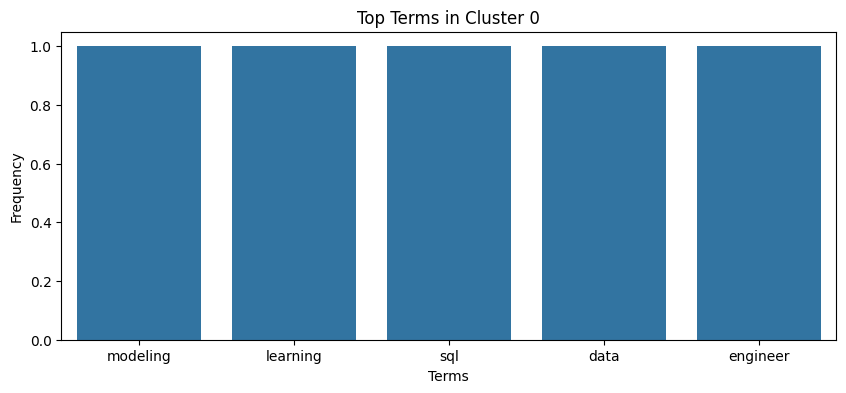

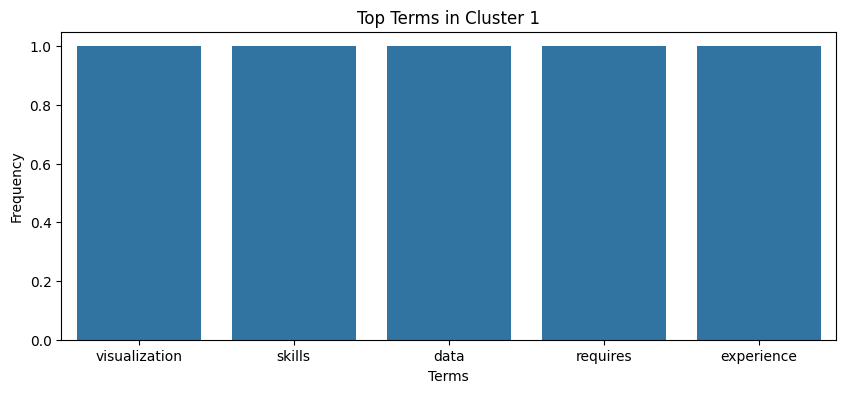

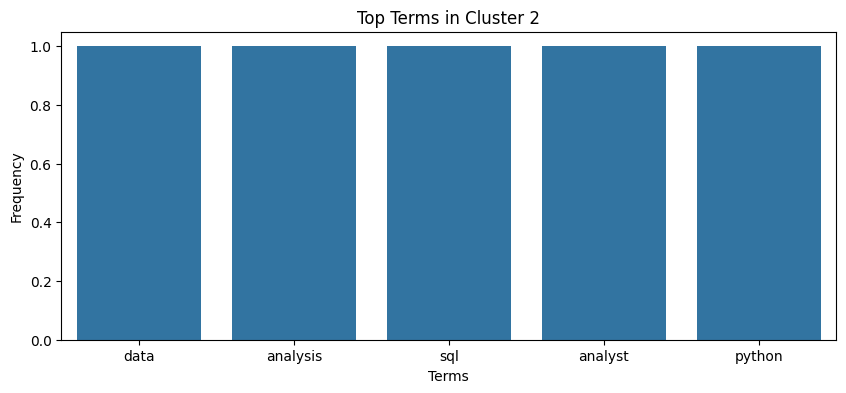

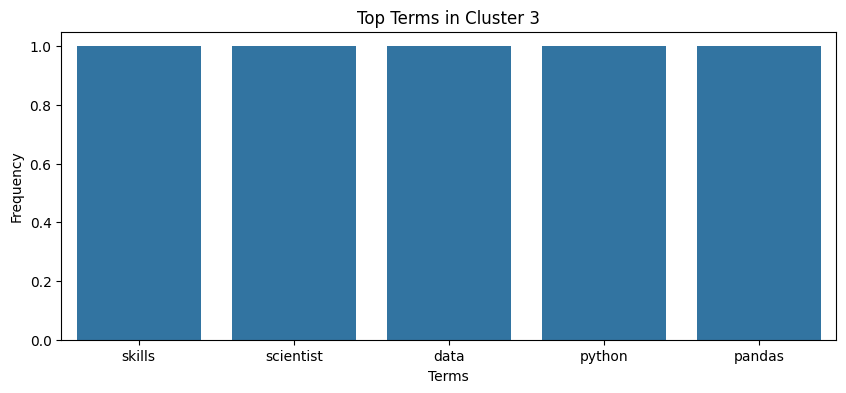

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Bar plot for the top terms in each cluster
cluster_terms = {
    0: ['modeling', 'learning', 'sql', 'data', 'engineer'],
    1: ['visualization', 'skills', 'data', 'requires', 'experience'],
    2: ['data', 'analysis', 'sql', 'analyst', 'python'],
    3: ['skills', 'scientist', 'data', 'python', 'pandas'],
}

for cluster, terms in cluster_terms.items():
    plt.figure(figsize=(10, 4))
    sns.barplot(x=terms, y=[1]*len(terms))
    plt.title(f'Top Terms in Cluster {cluster}')
    plt.xlabel('Terms')
    plt.ylabel('Frequency')
    plt.show()


In [54]:
import joblib  # Library to save the model
import logging

# Example DataFrame with job descriptions (can be combined with tweet text)
data = pd.DataFrame({
    'job_descriptions': [
        "Data Analyst with expertise in Python, SQL, and data analysis.",
        "Machine Learning Engineer: Python, SQL, and data modeling required.",
        "Looking for a Data Scientist with skills in Python, pandas, numpy, and machine learning.",
        "Job requires Tableau experience and data visualization skills."
    ]
})

# Apply preprocessing
data['processed'] = data['job_descriptions'].apply(preprocess_text)

# Join tokens back into strings for vectorization
data['processed_str'] = data['processed'].apply(lambda x: ' '.join(x))

# Create a CountVectorizer to transform the text into a matrix of token counts
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_str'])

# View the feature names (words)
print(vectorizer.get_feature_names_out())

# Choosing the number of clusters
num_clusters = 4  # Adjust as necessary
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign clusters back to the original DataFrame
data['cluster'] = kmeans.labels_

# Function to display top terms for each cluster
def display_cluster_terms(model, vectorizer, num_words=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        top_terms = [terms[ind] for ind in order_centroids[i, :num_words]]
        print("Top terms:", top_terms)

# Display the cluster terms
display_cluster_terms(kmeans, vectorizer)

# Save the trained model and vectorizer
joblib.dump(kmeans, r'C:\temp\kmeans_model.joblib')
joblib.dump(vectorizer, r'C:\temp\vectorizer.joblib')


print("Model and vectorizer saved successfully.")

['analysis' 'analyst' 'data' 'engineer' 'experience' 'expertise' 'job'
 'learning' 'looking' 'machine' 'modeling' 'numpy' 'pandas' 'python'
 'required' 'requires' 'scientist' 'skills' 'sql' 'tableau'
 'visualization']
Cluster 0:
Top terms: ['modeling', 'learning', 'sql', 'data', 'engineer', 'required', 'python', 'machine', 'analyst', 'experience']
Cluster 1:
Top terms: ['visualization', 'skills', 'data', 'requires', 'experience', 'job', 'tableau', 'looking', 'analyst', 'engineer']
Cluster 2:
Top terms: ['data', 'analysis', 'sql', 'analyst', 'python', 'expertise', 'looking', 'engineer', 'experience', 'job']
Cluster 3:
Top terms: ['skills', 'scientist', 'data', 'python', 'pandas', 'numpy', 'machine', 'looking', 'learning', 'visualization']
Model and vectorizer saved successfully.
